### Load modules

In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import random as rnd

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from flax.training import train_state  # Useful dataclass to keep train state
import optax

# PyTorch
import torch
import torch.utils.data as data

# check versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

# import priors 
#from models.priors import *

# import functions to load data
from models.data import *

# Test dist_euclid
#x1 = jnp.array([1,2,3])
#dist_euclid(x1,x1)

/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/anaconda3/envs/numpyro11_jax/lib/python3.10/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


Pytorch version:  1.12.1
Numpyro version:  0.11.0
JAX version:      0.4.12
Flax version:     0.6.1
Optax version:    0.1.4
Pythorch version: 3.10.11


### Setup arguments

In [2]:
args = {"seed": 0,
        
        # architecture
        "conditional": False,   # CVAE if True, VAE otherwise
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE setup    
        "batch_size": 12,
       }

### Generate data


In [3]:
train_set = Dataset_GP1d(n_dataPoints=args["input_dim"], seed=42)  
val_set =   Dataset_GP1d(n_dataPoints=args["input_dim"], seed=43)  
test_set =  Dataset_GP1d(n_dataPoints=args["input_dim"], seed=44)  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=args["batch_size"])

In [4]:
#for no, dt in enumerate(train_loader):
#    print(dt[2])

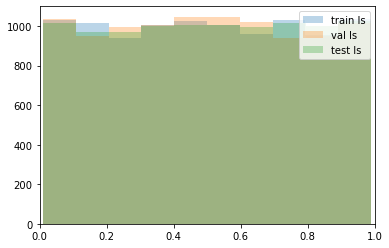

In [5]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set =   val_set.ls
ls_test_set = test_set.ls

plt.hist(ls_train_set, alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set,   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set,  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()

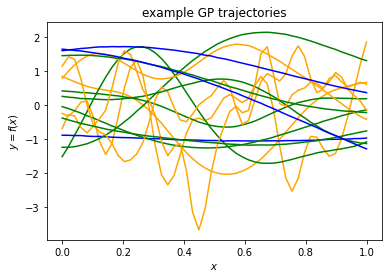

In [6]:
# check: what trajectories are we generating?

fig, ax = plt.subplots()
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [51]:
# import VAE architecture
from models.cvae import *

out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
conditional = args["conditional"]

batch_size  = args["batch_size"]

#### Test architecture

In [52]:
# Good idea to test archtecture (from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial9/AE_CIFAR10.html)

In [53]:
## Test encoder implementation

# Example data as input
batch = next(iter(train_loader)) # batch[0] - x, batch[1] - y, batch[2] - ls
print(batch[1].shape)

# Create encoder
encoder = Encoder(hidden_dim, latent_dim)

# Random key for initialization
rng = random.PRNGKey(0)

# Initialize parameters of encoder with random key and example data
params = encoder.init(rng, batch[1])['params']

# Apply encoder with parameters on the images
out = encoder.apply({'params': params}, batch[1])

# check that out is a tuple
isinstance(out, tuple)

assert out[0].shape == (batch_size, latent_dim)
assert out[1].shape == (batch_size, latent_dim)

del batch, encoder, params, out

(12, 50)


In [54]:
## Test dencoder implementation

# Example latents as input
rng, z_rng = random.split(rng)
z = random.normal(z_rng, (batch_size, latent_dim))
print(z.shape)

# Create decoder
decoder = Decoder(latent_dim, out_dim)

# Random key for initialization
rng = random.PRNGKey(1)

# Initialize parameters of decoder with random key and latents
rng, init_rng = random.split(rng)

params = decoder.init(init_rng, z)['params']

# Apply decoder with parameters on the datta
out = decoder.apply({'params': params}, z)

assert out.shape == (batch_size, out_dim)

del z, decoder, params, out


(12, 30)


In [55]:
## Test Autoencoder implementation

# Example data as input
batch = next(iter(train_loader))[1] # batch[0] - x, batch[1] - y, batch[2] - ls

# Random key for initialization
rng = random.PRNGKey(0)

# Create VAE
vae = VAE(hidden_dim, latent_dim, out_dim, conditional)

# Initialize parameters of encoder with random key and images
params = vae.init(rng, batch[1])['params']

# Apply vae with parameters on the images
out = vae.apply({'params': params}, batch[1]) 

# check that out is a tuple
isinstance(out, tuple)

assert len(out) == 4 # x, x_hat, z_mu, z_sd

del batch, vae, params, out


#### Define models

In [56]:
# define model
model = VAE(hidden_dim, latent_dim, out_dim, conditional)

# initialise parameters
key = jax.random.PRNGKey(0) 
params = model.init(key, train_set.y)

# optimizer
optimizer = optax.adam(learning_rate=0.001)

In [57]:
# check architecture
print(model.tabulate(key, train_set.y,
      console_kwargs={'force_terminal': False, 'force_jupyter': True}))

                                            VAE Summary                                            
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path               ┃ module  ┃ inputs            ┃ outputs             ┃ params                 ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│                    │ VAE     │ float32[10000,50] │ - float32[10000,50] │                        │
│                    │         │                   │ - float32[10000,50] │                        │
│                    │         │                   │ - float32[10000,30] │                        │
│                    │         │                   │ - float32[10000,30] │                        │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│ encoder            │ Encoder │ float32[10000,50] │ - float32[10000,30] │                        │
│                    │         │                   │ - float32[10000,30] │                        │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│ encoder/enc_hidden │ Dense   │ float32[10000,50] │ float32[10000,40]   │ bias: float32[40]      │
│                    │         │                   │                     │ kernel: float32[50,40] │
│                    │         │                   │                     │                        │
│                    │         │                   │                     │ 2,040 (8.2 KB)         │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│ encoder/z_mu       │ Dense   │ float32[10000,40] │ float32[10000,30]   │ bias: float32[30]      │
│                    │         │                   │                     │ kernel: float32[40,30] │
│                    │         │                   │                     │                        │
│                    │         │                   │                     │ 1,230 (4.9 KB)         │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│ encoder/z_sd       │ Dense   │ float32[10000,40] │ float32[10000,30]   │ bias: float32[30]      │
│                    │         │                   │                     │ kernel: float32[40,30] │
│                    │         │                   │                     │                        │
│                    │         │                   │                     │ 1,230 (4.9 KB)         │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│ decoder            │ Decoder │ float32[10000,30] │ float32[10000,50]   │                        │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│ decoder/dec_hidden │ Dense   │ float32[10000,30] │ float32[10000,40]   │ bias: float32[40]      │
│                    │         │                   │                     │ kernel: float32[30,40] │
│                    │         │                   │                     │                        │
│                    │         │                   │                     │ 1,240 (5.0 KB)         │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│ decoder/dec_out    │ Dense   │ float32[10000,40] │ float32[10000,50]   │ bias: float32[50]      │
│                    │         │                   │                     │ kernel: float32[40,50] │
│                    │         │                   │                     │                        │
│                    │         │                   │                     │ 2,050 (8.2 KB)         │
├────────────────────┼─────────┼───────────────────┼─────────────────────┼────────────────────────┤
│                    │         │                   │               Total │ 7,790 (31.2 KB)        │


In [11]:

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)
